In [1]:
import os
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.rec.reconstruction as rec
import algotom
import algotom.prep.calculation as calc
import h5py as h5f
import timeit
import multiprocessing as mp
from joblib import Parallel, delayed
from skimage.measure import profile_line
import ast

# %matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
ncore = mp.cpu_count()
print("CPU cores:", ncore)

/SNS/users/y9z/mamba/envs/rockit/lib/python3.11/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


CPU cores: 256


# Workflow starts here!

In [2]:
###################### need to change start
instrument = "/HFIR/CG1D"
# instrument = "/SNS/VENUS"
ipts="32260"
###################### need to change end

In [3]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
output_loc = instrument + "/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
os.listdir(output_loc)

['2024_03_06_FLiNaK_post_treatment_new_sample3.h5',
 '2024_03_06_FLiNaK_post_treatment_new_sample4.h5',
 '2024_03_05_FLiNaK_post_treatment_new_sample1.h5',
 '2024_01_19_Sample3_783proj_gridrec.h5',
 '2024_01_24_sample4_redo.h5',
 '2024_03_05_FLiNaK_post_treatment_new_sample2.h5',
 '2024_01_19_Sample1.h5',
 '2024_01_19_Sample3.h5',
 '2024_01_19_Sample2.h5']

In [12]:
###################### need to change start
hdf5_name = "2024_01_19_Sample3_783proj_gridrec"
hdf5 = output_loc + sample_name + ".h5"
num_of_str_to_rmv = 2
###################### need to change end
sample_name = rocku.hdf5_to_sample_name(hdf5_name, num_of_str_to_rmv)
sample_name

'2024_01_19_Sample3'

# Load hdf5 file

In [5]:
losa.get_hdf_tree(hdf5)
history_dict_str = losa.load_hdf(hdf5, key_path='tomo/recon/history')[0]
history_dict = ast.literal_eval(history_dict_str.decode("utf-8"))
history_dict

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (783,)
    │   ├── ang_rad (783,)
    │   ├── fname (783,)
    │   ├── proj000_idx (1,)
    │   ├── proj180_idx (1,)
    │   └── proj360_idx (1,)
    ├── proj
    │   │
    │   ├── proj_mlog_pre_ring (783, 1700, 800)
    │   ├── proj_mlog_pre_tilt (783, 1700, 800)
    │   ├── proj_mlog_to_recon (783, 1700, 800)
    │   └── proj_norm_pre_tilt (783, 1700, 800)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (1400, 100)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1700, 800)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── ang_idx_list (783,)
    │   ├── history (1,)
    │   └── recon_volume (1700, 400, 410)
    └── sino
        │
        ├── sino_mlog_pre_ring (1700, 783, 800)
        ├── sino_mlog_pre_tilt (1700, 783, 800)
        └── sino_mlog_to_recon (1700, 783, 800)


{'crop': True,
 'crop_roi_dict': {'left': 650, 'right': 1450, 'top': 250, 'bottom': 1950},
 'gamma_filter': True,
 'gamma_diff': 20,
 'normalization': True,
 'pixel_bin_size': 1,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi_dict': {'left': 0,
  'right': 100,
  'top': 0,
  'bottom': 1400},
 'minus_log': True,
 'tilt_corr_used': 'neutompy',
 'define_roi': False,
 'rot_center_180': 400.75,
 'rot_center_360': 399.02880758047104,
 'rot_center': 399.02880758047104,
 'tilt_corr_theta': -0.0706664415028529,
 'ring_removal': 'bm3dgpu',
 'pixel_size_um': 42.7,
 'recon_unit': 'cm-1',
 'ang_coverage': 'full',
 'recon_algo': 'gridrec',
 'recon_num_iter': 200,
 'recon_crop': True,
 'recon_crop_roi': {'left': 220, 'right': 630, 'top': 200, 'bottom': 600}}

In [6]:
# ang_deg = losa.load_hdf(hdf5, key_path='tomo/info/ang_deg')
# ang_rad = losa.load_hdf(hdf5, key_path='tomo/info/ang_rad')
ang_idx_list = losa.load_hdf(hdf5, key_path='tomo/recon/ang_idx_list')
proj000_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj000_idx')[0]
proj180_idx = losa.load_hdf(hdf5, key_path='tomo/info/proj180_idx')[0]
proj_mlog_to_recon = losa.load_hdf(hdf5, key_path='tomo/proj/proj_mlog_to_recon')
proj_norm = losa.load_hdf(hdf5, key_path='tomo/proj/proj_norm_pre_tilt')
ang_coverage = history_dict['ang_coverage']
recon_algo = history_dict['recon_algo']

In [7]:
recon = losa.load_hdf(hdf5, key_path='tomo/recon/recon_volume')

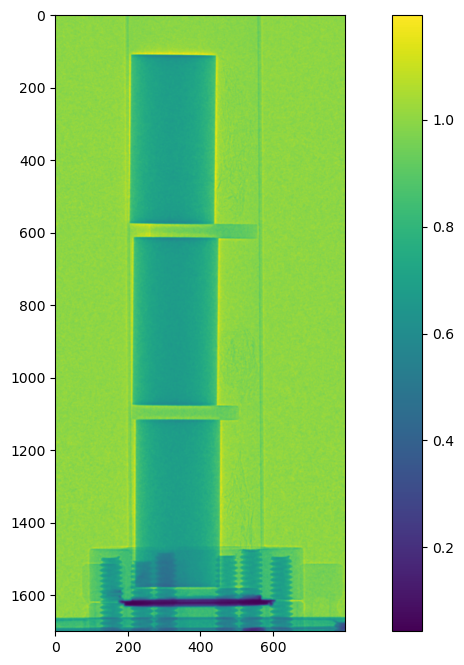

In [8]:
plt.imshow(proj_norm[400])
plt.colorbar()
plt.show()

# Export recon files

In [13]:
################ change save path for your own
name_str = None
# name_str = 'lamino'
############################################################
save_loc = instrument + "/IPTS-"+ipts+"/shared/processed_data/rockit/"
num_proj = len(ang_idx_list)
if ang_coverage != 'full':
    num_proj_str = str(num_proj) + 'of' + str(len(ang_rad))
else:
    num_proj_str = str(num_proj)
if name_str is not None:
    save_name_str = "_".join([sample_name, name_str, "{}proj".format(num_proj_str), recon_algo])# + "_roi"
else:
    save_name_str = "_".join([sample_name, "{}proj".format(num_proj_str), recon_algo])# + "_roi"
save_to = save_loc + save_name_str
print(save_to)
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

/HFIR/CG1D/IPTS-32260/shared/processed_data/rockit/2024_01_19_Sample3_783proj_gridrec


# Export proj files

In [9]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon/" + sample_name + "_norm"
dxchange.write_tiff_stack(proj_norm, fname=save_to + "/raw", overwrite=True, digit=4)
# dxchange.write_tiff(ob_output, fname=save_to + '/ob_0000', overwrite=True)
# dxchange.write_tiff(dc_output, fname=save_to + '/dc_0000', overwrite=True)